# <center>  User Referral Program - Take Home Challenge

# <font color='purple'> Challenge Description
<br>Company XYZ has started a new referral program on Oct, 31. Each user who refers a new user
will get 10$ in credit when the new user buys something.
<br>The program has been running for almost a month and the Growth Product Manager wants to
know if it's been successful. She is very excited cause, since the referral program started, the
company saw a spike in number of users and wants you to be able to give her some data she
can show to her boss. <br>
- Can you estimate the impact the program had on the site?
- Based on the data, what would you suggest to do as a next step?
- The referral program wasn't really tested in a rigorous way. It simply started on a given
day for all users and you are drawing conclusions by looking at the data before and after
the test started. What kinds of risks this approach presents? Can you think of a better
way to test the referral program and measure its impact?

In [27]:
# Import required libraries
import pandas as pd
import datetime as dt
from datetime import timedelta

import IPython.display
import warnings
warnings.filterwarnings('ignore')

## Import Data

In [2]:
referral = pd.read_csv('referral.csv')
referral.head()

,user_id,date,country,money_spent,is_referral,device_id
0,2,2015-10-03,FR,65,0,EVDCJTZMVMJDG
1,3,2015-10-03,CA,54,0,WUBZFTVKXGQQX
2,6,2015-10-03,FR,35,0,CBAPCJRTFNUJG
3,7,2015-10-03,UK,73,0,PRGXJZAJKMXRH
4,7,2015-10-03,MX,35,0,PRGXJZAJKMXRH


## Data Transformation / Exploration

In [28]:
referral['date'] = pd.to_datetime(referral['date'])

# Calculate the mumber of days between the 1st date and the launch of referral program AND between the last date and the launch of referral program
# Pass these into variables as I may need to use these later
launch = dt.datetime(2015, 10, 31)
n_days_pre = (launch - timedelta(days=1)) - referral['date'].min()
n_days_post = referral['date'].max() - launch

print(n_days_pre, n_days_post)

27 days 00:00:00 27 days 00:00:00


Pre and post period have the same number of days! So no need to subselect any dates in those

In [35]:
# Create a pre and post flag
def period_flag(date):
    if date < launch:
        return 'a. pre'
    else:
        return 'b. post'
    
referral['period_flag'] = referral['date'].apply(period_flag)
referral['period_flag'].value_counts()

b. post    50000
a. pre     47341
Name: period_flag, dtype: int64

In [42]:
# Create the metrics we require for the impact analysis by period_flag
df_metrics = pd.DataFrame([referral.groupby('period_flag').user_id.nunique(),
                           referral.groupby('period_flag').user_id.count(),
                           referral.groupby('period_flag').money_spent.sum(),
                           referral.groupby('period_flag').is_referral.sum()])

df_metrics = df_metrics.transpose()
df_metrics.columns = ['n_users', 'n_txns', 'money_spent', 'n_referrals' ]

# Derive indicators for direct comparison
df_metrics['avg_n_users_perday'] = df_metrics['n_users'] / n_days_post.days # using post is ok as pre and post have the same number of days
df_metrics['avg_n_txns_peruser'] = df_metrics['n_txns'] / df_metrics['n_users']
df_metrics['avg_money_spent_peruser'] = df_metrics['money_spent'] / df_metrics['n_users']
df_metrics['pct_referrals'] = df_metrics['n_referrals'] / df_metrics['n_txns']

df_metrics

,n_users,n_txns,money_spent,n_referrals,avg_n_users_perday,avg_n_txns_peruser,avg_money_spent_peruser,pct_referrals
period_flag,,,,,,,,
a. pre,5000,47341,2006396,0,185.185185,9.468200,401.279200,0.00000
b. post,18397,50000,2344003,28017,681.370370,2.717834,127.412241,0.56034


## <font color='blue'> Question 1. </font> Estimate impact the program had on the site

In [44]:
# Calculate difference between post and pre (in absolute value and %s)
df_impact = df_metrics.transpose()
df_impact['impact_value'] = df_impact['b. post'] - df_impact['a. pre']
df_impact['impact_pct'] = (df_impact['b. post'] - df_impact['a. pre']) / df_impact['a. pre']
df_impact['impact_pct'] = df_impact['impact_pct'].astype(float).map("{:.2%}".format)

df_impact

period_flag,a. pre,b. post,impact_value,impact_pct
n_users,5.000000e+03,1.839700e+04,13397.000000,267.94%
n_txns,4.734100e+04,5.000000e+04,2659.000000,5.62%
money_spent,2.006396e+06,2.344003e+06,337607.000000,16.83%
n_referrals,0.000000e+00,2.801700e+04,28017.000000,inf%
avg_n_users_perday,1.851852e+02,6.813704e+02,496.185185,267.94%
avg_n_txns_peruser,9.468200e+00,2.717834e+00,-6.750366,-71.30%
avg_money_spent_peruser,4.012792e+02,1.274122e+02,-273.866959,-68.25%
pct_referrals,0.000000e+00,5.603400e-01,0.560340,inf%


### Key Insights:
- +267% users between the pre and post referral launch! This is a huge increase and on that account, the program can be consider as a success.
- However, the avg number of txns and money spent per user both decreased by 71% and 68% respectively.
<br> <br>
__What does that mean__?
<br>
While the program was sucessful in bringing more new users, those are low txn and value or referral spent a lower amount of money. Let's profile referrals vs non-referrals in the post period to check which it is.

### Profiling of referrals in the post period

In [57]:
post_period = referral['period_flag'] == 'b. post'
df_metrics_post = pd.DataFrame([referral[post_period].groupby(['is_referral']).user_id.nunique(),
                           referral[post_period].groupby(['is_referral']).user_id.count(),
                           referral[post_period].groupby(['is_referral']).money_spent.sum()])

df_metrics_post = df_metrics_post.transpose()
df_metrics_post.columns = ['n_users', 'n_txns', 'money_spent']

df_metrics_post['avg_n_users_perday'] = df_metrics_post['n_users'] / n_days_post.days
df_metrics_post['avg_n_txns_peruser'] = df_metrics_post['n_txns'] / df_metrics_post['n_users']
df_metrics_post['avg_money_spent_peruser'] = df_metrics_post['money_spent'] / df_metrics_post['n_users']

df_metrics_post 

,n_users,n_txns,money_spent,avg_n_users_perday,avg_n_txns_peruser,avg_money_spent_peruser
is_referral,,,,,,
0,11539,21983,1028216,427.370370,1.905104,89.107895
1,12715,28017,1315787,470.925926,2.203460,103.483052


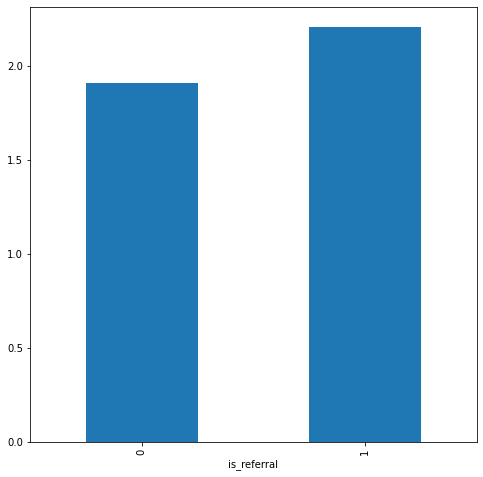

In [65]:
%matplotlib inline
df_metrics_post['avg_n_txns_peruser'].plot(kind='bar',figsize=(8,8))

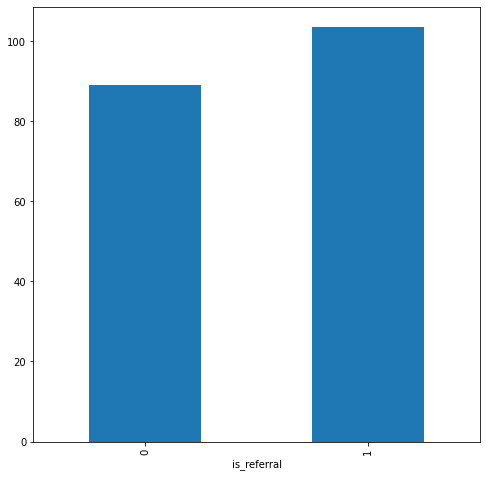

In [64]:
df_metrics_post['avg_money_spent_peruser'].plot(kind='bar',figsize=(8,8))

From our quick profiling analysis we see that in the post period referrals have a higher number of txns and they spent (on avg) more money

## <font color='blue'> Question 2. </font> Based on the data, what would you suggest to do as a next step?

- Explore changes in user behaviour between pre and post period for those who transacted in pre and post: This will tell us whether repeat users who referred actually spent less than those who repeat and did not referred anyone.


## <font color='blue'> Question 3. </font> 
## What kinds of risks this approach presents?
## Can you think of a better way to test the referral program and measure its impact?

- If there is seasonality in the website usage (txn/money spent), this type of approach may be skewed and the results can mislead us into thinking it the referral program worked whereas it is only the result of "organic" change.

- A/B tests: Run an experiment holding a control group (i.e. no referral) and also try different referral amount structurs to understand what type of incentive works best.